### **Music Genre Classification Using RNN with LSTM**<br>


In [ ]:
import json
import os
import math
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from keras.utils.np_utils import to_categorical 
from sklearn.metrics import classification_report  

from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# 1. Evaluate RNN with LSTM using Mel-frequency cepstral coefficients

## On GTZAN dataset

### 1 segment MFCCs for GTZAN

#### Code to prepare MFCCs for GTZAN dataset

In [ ]:
## GTZAN dataset details
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"
JSON_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan-1s.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to save GTZAN MFCC into data.json
## hop_length=512 num_segments=1
def save_mfcc(dataset_path, json_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=1):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)


Processing: blues
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00023.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00022.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00021.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00017.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00016.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00015.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00014.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00013.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00012.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00011.wav, segment:1
/conte

#### Visualize the MFCC

In [ ]:
with open('/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan-1s.json') as json_file:
    mfccData = json.load(json_file)
len(mfccData['mfcc'])

999

In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## View Mel-frequency cepstral coefficients (MFCCs)
narr = np.array(mfccData['mfcc'][500])
label = mfccData['labels'][500]
print("class: ",gtzan_genre_dict[label])
plt.figure(figsize=(10, 4))
librosa.display.specshow(narr.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

class:  jazz


#### Load the MFCCs for GTZAN dataset, build, train and evaluate the model

In [ ]:
GTZAN_DATA_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan-1s.json"

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


In [ ]:
# load data
X, y = load_data(GTZAN_DATA_PATH)

In [ ]:
print(X.shape)
print(y.shape)

(999, 1292, 20)
(999,)


In [ ]:
# get train, validation, test splits
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(561, 1292, 20)
(188, 1292, 20)
(250, 1292, 20)


In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add two LSTM layers
    model.add(keras.layers.LSTM(1024, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(512))

    # add a dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) # 1292, 20
gtzan_mfcc_1s_model = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.00075)
gtzan_mfcc_1s_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mfcc_1s_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1292, 1024)        4280320   
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               3147776   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 7,461,578
Trainable params: 7,461,578
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model MFCC GTZAN
gtzan_mfcc_1s_history = gtzan_mfcc_1s_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=20)

Epoch 1/20
18/18 [==============================] - 16s 714ms/step - loss: 2.3037 - accuracy: 0.1746 - val_loss: 1.9003 - val_accuracy: 0.3670
Epoch 2/20
18/18 [==============================] - 12s 664ms/step - loss: 1.9698 - accuracy: 0.3250 - val_loss: 1.7367 - val_accuracy: 0.3457
Epoch 3/20
18/18 [==============================] - 12s 660ms/step - loss: 1.6849 - accuracy: 0.3844 - val_loss: 1.5758 - val_accuracy: 0.4415
Epoch 4/20
18/18 [==============================] - 12s 663ms/step - loss: 1.5525 - accuracy: 0.4676 - val_loss: 1.8294 - val_accuracy: 0.3511
Epoch 5/20
18/18 [==============================] - 12s 664ms/step - loss: 1.5126 - accuracy: 0.4431 - val_loss: 1.5980 - val_accuracy: 0.3989
Epoch 6/20
18/18 [==============================] - 12s 661ms/step - loss: 1.3140 - accuracy: 0.5468 - val_loss: 1.4195 - val_accuracy: 0.4787
Epoch 7/20
18/18 [==============================] - 12s 663ms/step - loss: 1.1355 - accuracy: 0.5817 - val_loss: 1.4478 - val_accuracy: 0.4681

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


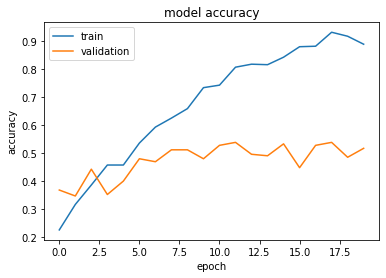

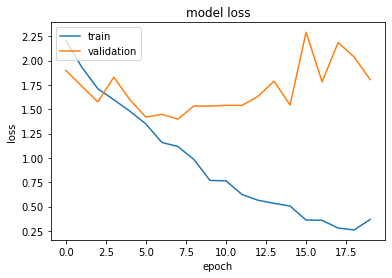

In [ ]:
show_summary_stats(gtzan_mfcc_1s_history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = gtzan_mfcc_1s_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

8/8 - 1s - loss: 2.0522 - accuracy: 0.5320

Test accuracy: 0.5320000052452087


In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mfcc_1s_model.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(188,) (188,)
              precision    recall  f1-score   support

       blues       0.55      0.32      0.40        19
   classical       0.87      0.68      0.76        19
     country       0.38      0.63      0.47        19
       disco       0.57      0.21      0.31        19
      hiphop       0.44      0.61      0.51        18
        jazz       0.50      0.53      0.51        19
       metal       0.83      0.53      0.65        19
         pop       0.57      0.84      0.68        19
      reggae       0.62      0.56      0.59        18
        rock       0.23      0.26      0.24        19

    accuracy                           0.52       188
   macro avg       0.56      0.52      0.51       188
weighted avg       0.56      0.52      0.51       188



### 5 segments MFCCs for GTZAN

#### Code to prepare MFCCs for GTZAN dataset

In [ ]:
## GTZAN dataset details
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"
JSON_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to save GTZAN MFCC into data.json
## hop_length=512 num_segments=5
def save_mfcc(dataset_path, json_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/blues/b

#### Visualize the MFCC

In [ ]:
with open('/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan.json') as json_file:
    mfccData = json.load(json_file)
len(mfccData['mfcc'])

4998

In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

class:  rock


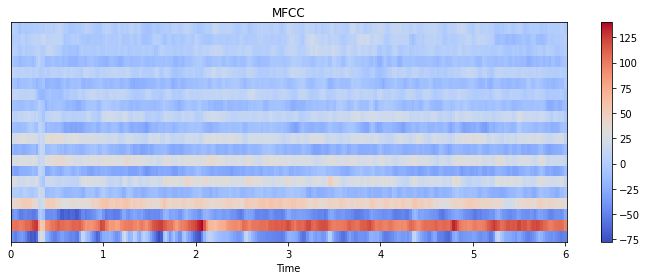

In [ ]:
## View Mel-frequency cepstral coefficients (MFCCs)
narr = np.array(mfccData['mfcc'][4500])
label = mfccData['labels'][4500]
print("class: ",gtzan_genre_dict[label])
plt.figure(figsize=(10, 4))
librosa.display.specshow(narr.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()


#### Load the MFCCs for GTZAN dataset, build, train and evaluate the model

In [ ]:
GTZAN_DATA_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan.json"

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


In [ ]:
# load data
X, y = load_data(GTZAN_DATA_PATH)

In [ ]:
print(X.shape)
print(y.shape)

(4998, 259, 20)
(4998,)


In [ ]:
# get train, validation, test splits
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(2811, 259, 20)
(937, 259, 20)
(1250, 259, 20)


In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add two LSTM layers
    model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128))

    # add a dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) # 259, 20
gtzan_mfcc_5s_model = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.00075)
gtzan_mfcc_5s_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mfcc_5s_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 259, 256)          283648    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 489,674
Trainable params: 489,674
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model MFCC GTZAN
gtzan_mfcc_5s_history = gtzan_mfcc_5s_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=128, epochs=20)

Epoch 1/20
22/22 [==============================] - 5s 105ms/step - loss: 2.0233 - accuracy: 0.2771 - val_loss: 1.5589 - val_accuracy: 0.4600
Epoch 2/20
22/22 [==============================] - 1s 66ms/step - loss: 1.5220 - accuracy: 0.4702 - val_loss: 1.3706 - val_accuracy: 0.5443
Epoch 3/20
22/22 [==============================] - 1s 66ms/step - loss: 1.3498 - accuracy: 0.5214 - val_loss: 1.2868 - val_accuracy: 0.5176
Epoch 4/20
22/22 [==============================] - 1s 65ms/step - loss: 1.2222 - accuracy: 0.5766 - val_loss: 1.2400 - val_accuracy: 0.5646
Epoch 5/20
22/22 [==============================] - 1s 66ms/step - loss: 1.0451 - accuracy: 0.6458 - val_loss: 1.1859 - val_accuracy: 0.5710
Epoch 6/20
22/22 [==============================] - 1s 66ms/step - loss: 0.9963 - accuracy: 0.6580 - val_loss: 1.1153 - val_accuracy: 0.6030
Epoch 7/20
22/22 [==============================] - 1s 66ms/step - loss: 0.9056 - accuracy: 0.6913 - val_loss: 1.1642 - val_accuracy: 0.5934
Epoch 8/20
2

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


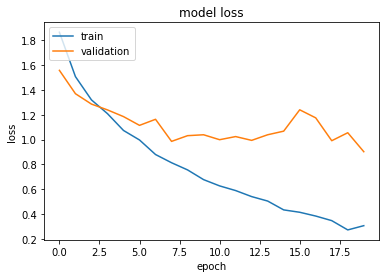

In [ ]:
show_summary_stats(gtzan_mfcc_5s_history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = gtzan_mfcc_5s_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

40/40 - 1s - loss: 0.9360 - accuracy: 0.7264

Test accuracy: 0.7264000177383423


In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mfcc_5s_model.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(937,) (937,)
              precision    recall  f1-score   support

       blues       0.75      0.67      0.71        94
   classical       0.92      0.91      0.92        94
     country       0.57      0.83      0.67        93
       disco       0.63      0.70      0.67        94
      hiphop       0.69      0.72      0.71        93
        jazz       0.80      0.78      0.79        94
       metal       0.91      0.76      0.83        94
         pop       0.78      0.90      0.84        94
      reggae       0.73      0.62      0.67        94
        rock       0.58      0.41      0.48        93

    accuracy                           0.73       937
   macro avg       0.74      0.73      0.73       937
weighted avg       0.74      0.73      0.73       937



## On FMA dataset

### Code to prepare MFCCs for FMA dataset


In [ ]:
## Free Music Archive(FMA) dataset details
FMA_Audio_path="/content/gdrive/MyDrive/fma_small"
FMA_Json_data = "/content/gdrive/MyDrive/fma_small/data-fma.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
def get_tids_from_directory(audio_dir):
    """Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids

In [ ]:
print("tids ",get_tids_from_directory("/content/gdrive/MyDrive/fma_small"))

tids  [150062, 150073, 150015, 150287, 150017, 150266, 150078, 150018, 150080, 150265, 150288, 150064, 150063, 150268, 150079, 150267, 148113, 148609, 148131, 148077, 148217, 148773, 148516, 148290, 148028, 148517, 148208, 148532, 148032, 148302, 148216, 148441, 148519, 148289, 148075, 148114, 148213, 148212, 148305, 148186, 148214, 148031, 148287, 148070, 148218, 148430, 148215, 148211, 148535, 148606, 148078, 148235, 148303, 148602, 148608, 148099, 148443, 148611, 148082, 148121, 148288, 148002, 148605, 148234, 148518, 148233, 148112, 148120, 148587, 148285, 148585, 148537, 148246, 148190, 148066, 148168, 148612, 148133, 148429, 148286, 148074, 148079, 148586, 148130, 148076, 148613, 148513, 148210, 148444, 148439, 148132, 148124, 148187, 148607, 148604, 148510, 148536, 148514, 148610, 148231, 148584, 148603, 151404, 154413, 154308, 154307, 154306, 154303, 154309, 154305, 154414, 149075, 149712, 149778, 149102, 149101, 149452, 149714, 149687, 149143, 149139, 149523, 149083, 149185, 1

In [ ]:
## Method to get a track path given data directory and track_id
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(int(track_id))
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [ ]:
tids = get_tids_from_directory(FMA_Audio_path)
print(len(tids))
print(type(tids[0]))

8000
<class 'int'>


In [ ]:
## Read the tracks details from csv to a dataframe
df = pd.read_csv("/content/gdrive/MyDrive/fma_small/tracks_with_required_columns.csv", index_col=0, header=[0, 1])

In [ ]:
df.head()

set            track
             split subset genre_top
track_id                           
2         training  small   Hip-Hop
5         training  small   Hip-Hop
10        training  small       Pop
140       training  small      Folk
141       training  small      Folk

In [ ]:
df['track_id'] = df.index
df.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [ ]:
print(df.shape)
df[('track', 'genre_top')].unique()

(8000, 4)


array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [ ]:
## Creating a dictionary of labels
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [ ]:
## Method to save FMA MFCC into data.json
## hop_length=1024
def save_mfcc(dataset_path, json_path, dict_genres, num_mfcc=20, n_fft=2048, hop_length=1024, num_segments=2):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i in dict_genres.keys():
      data["mapping"].append(i)
    count = 0
    for index, row in df.iterrows():
        with warnings.catch_warnings():
            try:
                warnings.simplefilter("ignore")
                count += 1
                track_id = int(row['track_id'])
                genre = str(row[('track', 'genre_top')])
                file_path = get_audio_path(dataset_path, track_id)
                signal, sample_rate = librosa.load(file_path)
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(dict_genres.get(genre))
                        print("{}, segment:{}".format(file_path, d+1))
                    # print("data: ",data)
                if count % 100 == 0:
                    print("Currently processing: ", count)
                # break
                
            except:
                print("Couldn't process: ", count)
                continue


    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
now = datetime.now()
save_mfcc(FMA_Audio_path, FMA_Json_data, dict_genres, num_mfcc=20, n_fft=2048, hop_length=1024, num_segments=2)
print("Time taken: ", (datetime.now() - now).total_seconds())

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/fma_small/115/115944.mp3, segment:2
/content/gdrive/MyDrive/fma_small/115/115948.mp3, segment:1
/content/gdrive/MyDrive/fma_small/115/115948.mp3, segment:2
/content/gdrive/MyDrive/fma_small/116/116029.mp3, segment:1
/content/gdrive/MyDrive/fma_small/116/116029.mp3, segment:2
/content/gdrive/MyDrive/fma_small/116/116068.mp3, segment:1
/content/gdrive/MyDrive/fma_small/116/116068.mp3, segment:2
/content/gdrive/MyDrive/fma_small/116/116098.mp3, segment:1
/content/gdrive/MyDrive/fma_small/116/116098.mp3, segment:2
/content/gdrive/MyDrive/fma_small/116/116099.mp3, segment:1
/content/gdrive/MyDrive/fma_small/116/116099.mp3, segment:2
/content/gdrive/MyDrive/fma_small/116/116101.mp3, segment:1
/content/gdrive/MyDrive/fma_small/116/116101.mp3, segment:2
/content/gdrive/MyDrive/fma_small/116/116116.mp3, segment:1
/content/gdrive/MyDrive/fma_small/116/116116.mp3, segment:2
/content/gdrive/MyDrive/fma_small/116/116119.mp3,

### Load the MFCCs for FMA dataset, build, train and evaluate the model

In [ ]:
## Path to MFCC of FMA dataset
FMA_DATA_PATH = "/content/gdrive/MyDrive/fma_small/data-fma.json"

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X,y

In [ ]:
# load data
X,y = load_data(FMA_DATA_PATH)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
X,y = unison_shuffled_copies(X,y)

In [ ]:
print(X.shape)
print(y.shape)

(15982, 323, 20)
(15982,)


In [ ]:
# get train, validation, test splits
# create train, validation and test split
X_train_fma, X_test_fma, y_train_fma, y_test_fma = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train_fma, X_validation_fma, y_train_fma, y_validation_fma = train_test_split(X_train_fma, y_train_fma, random_state=42, stratify=y_train_fma, test_size=0.25)

In [ ]:
print(X_train_fma.shape)
print(X_validation_fma.shape)
print(X_test_fma.shape)

(8989, 323, 20)
(2997, 323, 20)
(3996, 323, 20)


In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add two LSTM layers
    model.add(keras.layers.LSTM(326, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128))

    # add a dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.4))

    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

In [ ]:
# create network layers for FMA
input_shape_fma = (X_train_fma.shape[1], X_train_fma.shape[2]) 
fma_model = build_model(input_shape_fma)

In [ ]:
# compile model for FMA
optimiser_fma = keras.optimizers.Adam(learning_rate=0.00075)
fma_model.compile(optimizer=optimiser_fma,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fma_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 323, 326)          452488    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               232960    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 694,224
Trainable params: 694,224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model for 30 epochs FMA MFCC
fma_trained_history = fma_model.fit(X_train_fma, y_train_fma, validation_data=(X_validation_fma, y_validation_fma), batch_size=128, epochs=20)

Epoch 1/20
71/71 [==============================] - 11s 110ms/step - loss: 1.9377 - accuracy: 0.2420 - val_loss: 1.6750 - val_accuracy: 0.3981
Epoch 2/20
71/71 [==============================] - 7s 99ms/step - loss: 1.7143 - accuracy: 0.3619 - val_loss: 1.5919 - val_accuracy: 0.4314
Epoch 3/20
71/71 [==============================] - 7s 99ms/step - loss: 1.6137 - accuracy: 0.4177 - val_loss: 1.5609 - val_accuracy: 0.4294
Epoch 4/20
71/71 [==============================] - 7s 99ms/step - loss: 1.5664 - accuracy: 0.4374 - val_loss: 1.5341 - val_accuracy: 0.4484
Epoch 5/20
71/71 [==============================] - 7s 99ms/step - loss: 1.4975 - accuracy: 0.4549 - val_loss: 1.5044 - val_accuracy: 0.4648
Epoch 6/20
71/71 [==============================] - 7s 99ms/step - loss: 1.4135 - accuracy: 0.5026 - val_loss: 1.4770 - val_accuracy: 0.4708
Epoch 7/20
71/71 [==============================] - 7s 100ms/step - loss: 1.3757 - accuracy: 0.5108 - val_loss: 1.4373 - val_accuracy: 0.4845
Epoch 8/20

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


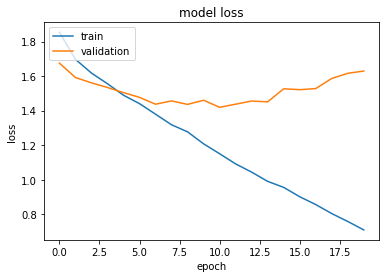

In [ ]:
# plot accuracy/error for training and validation
show_summary_stats(fma_trained_history)

In [ ]:
# evaluate model on test set
test_loss_fma, test_acc_fma = fma_model.evaluate(X_test_fma, y_test_fma, verbose=2)
print('\nTest accuracy:', test_acc_fma)

125/125 - 2s - loss: 1.6394 - accuracy: 0.5195

Test accuracy: 0.5195195078849792


In [ ]:
genres_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock':7}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation_fma)
y_true = np.argmax(y_validReport, axis=1)
y_pred = fma_model.predict(X_validation_fma)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = genres_dict.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(2997,) (2997,)
               precision    recall  f1-score   support

   Electronic       0.53      0.53      0.53       375
 Experimental       0.41      0.34      0.37       375
         Folk       0.55      0.52      0.54       375
      Hip-Hop       0.70      0.56      0.62       374
 Instrumental       0.40      0.60      0.48       374
International       0.50      0.55      0.53       375
          Pop       0.34      0.28      0.31       375
         Rock       0.63      0.64      0.63       374

     accuracy                           0.50      2997
    macro avg       0.51      0.50      0.50      2997
 weighted avg       0.51      0.50      0.50      2997



# 2. Evaluate RNN with LSTM using Mel-Spectograms



## On FMA dataset

### Code to prepare Mel-Spectrograms for FMA dataset

In [ ]:
## Read the tracks details from csv to a dataframe
df = pd.read_csv("/content/gdrive/MyDrive/fma_small/tracks_with_required_columns.csv", index_col=0, header=[0, 1])

In [ ]:
df.shape

(8000, 3)

In [ ]:
df.head()

set            track
             split subset genre_top
track_id                           
2         training  small   Hip-Hop
5         training  small   Hip-Hop
10        training  small       Pop
140       training  small      Folk
141       training  small      Folk

In [ ]:
df['track_id'] = df.index
df.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [ ]:
df[('track', 'genre_top')].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [ ]:
df[('set', 'split')].unique()

array(['training', 'validation', 'test'], dtype=object)

In [ ]:
df_train = df[df[('set', 'split')]=='training']
df_test = df[df[('set', 'split')]=='test']
df_valid = df[df[('set', 'split')]=='validation']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 4) (800, 4) (800, 4)


In [ ]:
genres_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock':7}

In [ ]:
## Method to get a track path given data directory and track_id
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(int(track_id))
    # return os.path.join(audio_dir, track_id[:3], track_id + '.mp3')
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [ ]:
def create_spectogram(audio_dir, track_id, n_fft, hop_length):
    filepath = get_audio_path(audio_dir, track_id)
    y, sr = librosa.load(filepath)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length, n_mels=128)
    spect = librosa.core.pcen(spect, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
    return spect.T

In [ ]:
def create_X_y_data_array(df, audio_dir, n_fft, hop_length):

    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        with warnings.catch_warnings():
            try:
                warnings.simplefilter("ignore")
                count += 1
                track_id = int(row['track_id'])
                genre = str(row[('track', 'genre_top')])
                spect = create_spectogram(audio_dir, track_id, n_fft, hop_length)

                # Normalize for small shape differences
                spect = spect[:640, :]
                X_spect = np.append(X_spect, [spect], axis=0)
                genres.append(genres_dict[genre])
                if count % 100 == 0:
                    print("Currently processing: ", count)
            except Exception as e:
                print(e)
                print("Couldn't process: ", count)
                continue
            # break
    y_arr = np.array(genres)
    return X_spect, y_arr

In [ ]:
FMA_audio_path = "/content/gdrive/MyDrive/fma_small"

In [ ]:
X_test, y_test = create_X_y_data_array(df_test, FMA_audio_path,2048, 512)
print(X_test.shape, y_test.shape)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
(800, 640, 128) (800,)


In [ ]:
np.savez('test_data', X_test, y_test)

In [ ]:
X_valid, y_valid = create_X_y_data_array(df_valid, FMA_audio_path,2048, 512)
print(X_valid.shape, y_valid.shape)
np.savez('validation_data', X_valid, y_valid)


Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
(800, 640, 128) (800,)


Splitting the training dataset into 4 smaller size. (As it takes lot of time to process, sometimes session crashes due to RAM limitation.)

In [ ]:
def split_df_into_smaller(df, chunk_size = 1600): 
    list_of_df = list()
    number_of_chunks = len(df) // chunk_size + 1
    for i in range(number_of_chunks):
        list_of_df.append(df[i*chunk_size:(i+1)*chunk_size])
    return list_of_df

In [ ]:
list_df = split_df_into_smaller(df_train)
df1_train = list_df[0]
df2_train = list_df[1]
df3_train = list_df[2]
df4_train = list_df[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

(1600, 4) (1600, 4) (1600, 4) (1600, 4)


In [ ]:
X_train1, y_train1 = create_X_y_data_array(df1_train, FMA_audio_path,2048, 512)
print(X_train1.shape, y_train1.shape)
print("Saving train1 data.")
np.savez('train_data_1', X_train1, y_train1)

X_train2, y_train2 = create_X_y_data_array(df2_train, FMA_audio_path,2048, 512)
print(X_train2.shape, y_train2.shape)
print("Saving train2 data.")
np.savez('train_data_2', X_train2, y_train2)

X_train3, y_train3 = create_X_y_data_array(df3_train, FMA_audio_path,2048, 512)
print(X_train3.shape, y_train3.shape)
print("Saving train3 data.")
np.savez('train_data_3', X_train3, y_train3)

X_train4, y_train4 = create_X_y_data_array(df4_train, FMA_audio_path,2048, 512)
print(X_train4.shape, y_train4.shape)
print("Saving train4 data.")
np.savez('train_data_4', X_train4, y_train4)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600
(1600, 640, 128) (1600,)
Saving train1 data.
Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600
(1600, 640, 128) (1600,)
Saving train2 data.
Currently processing:  100
Curre

In [ ]:
npzfile = np.load('train_data_1.npz')
print(npzfile.files)
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']
print(X_train1.shape, y_train1.shape)

['arr_0', 'arr_1']
(1600, 640, 128) (1600,)


In [ ]:

npzfile = np.load('train_data_2.npz')
print(npzfile.files)
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']
print(X_train2.shape, y_train2.shape)

['arr_0', 'arr_1']
(1600, 640, 128) (1600,)


In [ ]:
npzfile = np.load('train_data_3.npz')
print(npzfile.files)
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']
print(X_train3.shape, y_train3.shape)

['arr_0', 'arr_1']
(1595, 640, 128) (1595,)


In [ ]:
npzfile = np.load('train_data_4.npz')
print(npzfile.files)
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']
print(X_train4.shape, y_train4.shape)

['arr_0', 'arr_1']
(1599, 640, 128) (1599,)


In [ ]:
npzfile = np.load('validation_data.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [ ]:
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394,)


In [ ]:
## Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

1.0 1.6902564216121239 1.0582864938311576


In [ ]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

0.0 0.5248802461899077 0.054973862404556754


In [ ]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

In [ ]:
print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

Shapes are:  (6394, 640, 128) (800, 640, 128) (6394,) (800,)


In [ ]:
np.savez('shuffled_train', X_train, y_train)
np.savez('shuffled_valid', X_valid, y_valid)

### Visualize Mel Spectrogram

In [ ]:
genres_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock':7}

In [ ]:
reverse_map = {v: k for k, v in genres_dict.items()}

Electronic


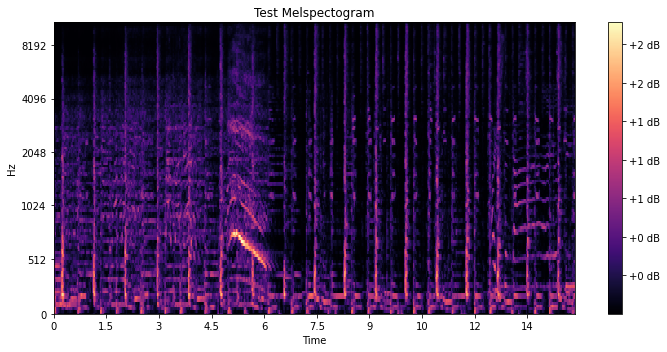

In [ ]:
num = 2500
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### Load the Mel Spectrograms for FMA dataset, build, train and evaluate the model

In [ ]:
npzfile = np.load('/content/gdrive/MyDrive/fma_small/shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [ ]:
npzfile = np.load('/content/shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(6394, 640, 128)
(6394,)
(800, 640, 128)
(800,)


In [ ]:
print(np.amin(X_train), np.amax(X_train), np.mean(X_train))

0.0 0.5248802461899077 0.05497386240455689


In [ ]:
print(np.amin(X_valid), np.amax(X_valid), np.mean(X_valid))

0.0 0.5148871936493267 0.0561631155108033


In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape, classes):

    # create the sequential model
    model = keras.Sequential()

    # add two LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    # model.add(keras.layers.LSTM(32, return_sequences=True))
    model.add(keras.layers.LSTM(64))
    # add a dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    

    # output layer
    model.add(keras.layers.Dense(classes, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
print(input_shape)
fma_mels_model = build_model(input_shape,8)

(640, 128)


In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.0075)
fma_mels_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fma_mels_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 640, 64)           49408     
_________________________________________________________________
lstm_80 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_72 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 8)                 520       
Total params: 87,112
Trainable params: 87,112
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model FMA MELSpectrogram
history = fma_mels_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=25)

Epoch 1/25
100/100 [==============================] - 9s 68ms/step - loss: 2.1334 - accuracy: 0.1594 - val_loss: 1.9591 - val_accuracy: 0.2250
Epoch 2/25
100/100 [==============================] - 6s 61ms/step - loss: 1.9558 - accuracy: 0.2394 - val_loss: 1.8490 - val_accuracy: 0.2887
Epoch 3/25
100/100 [==============================] - 6s 62ms/step - loss: 1.8685 - accuracy: 0.2827 - val_loss: 1.7887 - val_accuracy: 0.3262
Epoch 4/25
100/100 [==============================] - 6s 61ms/step - loss: 1.8019 - accuracy: 0.3280 - val_loss: 1.7658 - val_accuracy: 0.3288
Epoch 5/25
100/100 [==============================] - 6s 61ms/step - loss: 1.7745 - accuracy: 0.3402 - val_loss: 1.7417 - val_accuracy: 0.3162
Epoch 6/25
100/100 [==============================] - 6s 62ms/step - loss: 1.7381 - accuracy: 0.3518 - val_loss: 1.7028 - val_accuracy: 0.3613
Epoch 7/25
100/100 [==============================] - 6s 61ms/step - loss: 1.7082 - accuracy: 0.3693 - val_loss: 1.6524 - val_accuracy: 0.3738

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


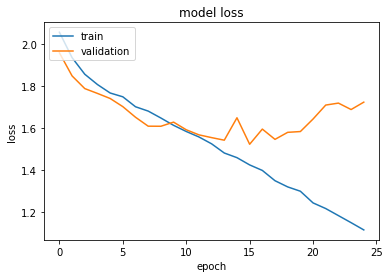

In [ ]:
show_summary_stats(history)

In [ ]:
npzfile = np.load('test_data.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [ ]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1.0000000000003177 1.6821718493756723 1.0606265312779075


In [ ]:
X_test = np.log(X_test_raw)

In [ ]:
print(X_test.shape)
print(y_test.shape)

(800, 640, 128)
(800,)


In [ ]:
# y_test = keras.utils.to_categorical(y_test, num_classes=8)
fma_mels_model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 24ms/step - loss: 1.9457 - accuracy: 0.3925


[1.9456955194473267, 0.39250001311302185]

In [ ]:
genres_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock':7}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_valid)
y_true = np.argmax(y_validReport, axis=1)
y_pred = fma_mels_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = genres_dict.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.45      0.52      0.48       100
 Experimental       0.35      0.39      0.37       100
         Folk       0.63      0.47      0.54       100
      Hip-Hop       0.69      0.60      0.64       100
 Instrumental       0.41      0.36      0.39       100
International       0.39      0.51      0.44       100
          Pop       0.15      0.13      0.14       100
         Rock       0.53      0.57      0.55       100

     accuracy                           0.44       800
    macro avg       0.45      0.44      0.44       800
 weighted avg       0.45      0.44      0.44       800



## On GTZAN dataset

### Creating 1 segment of Mel Specs on each audio 

#### Code to prepare Mel-Spectrograms using single segment and pcen normalization for GTZAN dataset

In [ ]:
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"

In [ ]:
## Method to save GTZAN Melspectrogram 
## hop_length=512
def save_mels_single_segment_gtzan(dataset_path, n_mels=128, n_fft=2048, hop_length=512):

    X_spect = np.empty((0, 640, 128))
    m_specs = []
    genres = []
    count = 0

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:
                count+=1
		            # load audio file
                file_path = os.path.join(dirpath, f)
                y, sr = librosa.load(file_path)

                # extract melspect
                mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                mels = librosa.core.pcen(mels, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
                # mels = librosa.power_to_db(mels, ref=np.max)
                mels = mels.T

                # Normalize for small shape differences
                mels = mels[:640, :]

                X_spect = np.append(X_spect, [mels], axis=0)
                genres.append(i-1)
                print("Currently Processing: ",count)
            
    # X_spect = np.array(m_specs)
    y_arr = np.array(genres)
    return X_spect, y_arr

In [ ]:
X_whole, y_whole = save_mels_single_segment_gtzan(DATASET_PATH)


Processing: blues
Currently Processing:  1
Currently Processing:  2
Currently Processing:  3
Currently Processing:  4
Currently Processing:  5
Currently Processing:  6
Currently Processing:  7
Currently Processing:  8
Currently Processing:  9
Currently Processing:  10
Currently Processing:  11
Currently Processing:  12
Currently Processing:  13
Currently Processing:  14
Currently Processing:  15
Currently Processing:  16
Currently Processing:  17
Currently Processing:  18
Currently Processing:  19
Currently Processing:  20
Currently Processing:  21
Currently Processing:  22
Currently Processing:  23
Currently Processing:  24
Currently Processing:  25
Currently Processing:  26
Currently Processing:  27
Currently Processing:  28
Currently Processing:  29
Currently Processing:  30
Currently Processing:  31
Currently Processing:  32
Currently Processing:  33
Currently Processing:  34
Currently Processing:  35
Currently Processing:  36
Currently Processing:  37
Currently Processing:  38
Cu

In [ ]:
print(X_whole.shape)
print(y_whole.shape)

(1000, 640, 128)
(1000,)


In [ ]:
np.save("gdrive/MyDrive/gtzan_genres_data/gtzan_X_whole_1s.npy", X_whole)
np.save("gdrive/MyDrive/gtzan_genres_data/gtzan_y_whole_1s.npy", y_whole)

#### Load the Mel-Spectrograms created above with 1 segment, build, train and evaluate the model

In [ ]:
X_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_X_whole_1s.npy")
y_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_y_whole_1s.npy")

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X_whole, y_whole, random_state=42, stratify=y_whole, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
X_train.shape

(600, 640, 128)

In [ ]:
X_validation.shape

(200, 640, 128)

In [ ]:
X_test.shape

(200, 640, 128)

In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add two LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # add a dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
gtzan_mels_1s_model = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.0005)
gtzan_mels_1s_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mels_1s_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 640, 64)           49408     
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                650       
Total params: 87,242
Trainable params: 87,242
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model with Mel-Spectrogram on  GTZAN
gtzan_mels_1s_history = gtzan_mels_1s_model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                                          batch_size=64, epochs=30 )


Epoch 1/30
10/10 [==============================] - 5s 175ms/step - loss: 2.2755 - accuracy: 0.1564 - val_loss: 2.2255 - val_accuracy: 0.1900
Epoch 2/30
10/10 [==============================] - 1s 81ms/step - loss: 2.2076 - accuracy: 0.1703 - val_loss: 2.1509 - val_accuracy: 0.2400
Epoch 3/30
10/10 [==============================] - 1s 78ms/step - loss: 2.1316 - accuracy: 0.2352 - val_loss: 2.0521 - val_accuracy: 0.2800
Epoch 4/30
10/10 [==============================] - 1s 81ms/step - loss: 2.0542 - accuracy: 0.2813 - val_loss: 1.9905 - val_accuracy: 0.3250
Epoch 5/30
10/10 [==============================] - 1s 78ms/step - loss: 2.0027 - accuracy: 0.3077 - val_loss: 2.0164 - val_accuracy: 0.2750
Epoch 6/30
10/10 [==============================] - 1s 80ms/step - loss: 1.9637 - accuracy: 0.3223 - val_loss: 1.9276 - val_accuracy: 0.3400
Epoch 7/30
10/10 [==============================] - 1s 80ms/step - loss: 1.8862 - accuracy: 0.3392 - val_loss: 1.8796 - val_accuracy: 0.3500
Epoch 8/30
1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


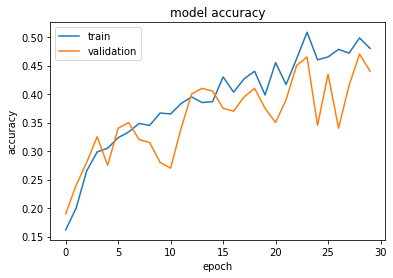

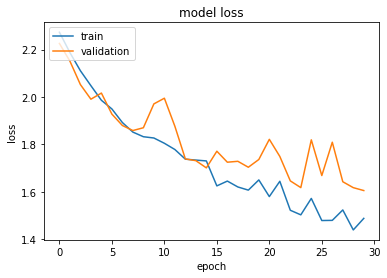

In [ ]:
show_summary_stats(gtzan_mels_1s_history)

In [ ]:
gtzan_mels_1s_model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 30ms/step - loss: 1.5159 - accuracy: 0.4800


[1.5159144401550293, 0.47999998927116394]

In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mels_1s_model.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(200,) (200,)
              precision    recall  f1-score   support

       blues       0.29      0.25      0.27        20
   classical       0.71      0.85      0.77        20
     country       0.27      0.20      0.23        20
       disco       0.22      0.25      0.23        20
      hiphop       0.60      0.15      0.24        20
        jazz       0.36      0.40      0.38        20
       metal       0.57      0.60      0.59        20
         pop       0.52      0.75      0.61        20
      reggae       0.65      0.55      0.59        20
        rock       0.30      0.40      0.34        20

    accuracy                           0.44       200
   macro avg       0.45      0.44      0.43       200
weighted avg       0.45      0.44      0.43       200



### Creating 5 segments of Mel Specs on each audio



#### Code to prepare Mel-Spectrograms using 5 segments and pcen normalization for GTZAN dataset

In [ ]:
## GTZAN dataset details
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"
JSON_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan-mels.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to save GTZAN MFCC into data.json
## hop_length=512
def save_mels_gtzan(dataset_path, json_path, n_mels=128, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mels": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mels_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                y, sr = librosa.load(file_path)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mels = librosa.feature.melspectrogram(y[start:finish], sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                    mels = librosa.core.pcen(mels, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
                    mels = mels.T

                    # store only mfcc feature with expected number of vectors
                    if len(mels) == num_mels_vectors_per_segment:
                        data["mels"].append(mels.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))


    # save MFCCs to json file
    # with open(json_path, "w") as fp:
    #     json.dump(data, fp, indent=4)

    return data["mels"], data["labels"]

In [ ]:
now = datetime.now()
X_whole, y_whole = save_mels_gtzan(DATASET_PATH,JSON_PATH)
print("Time taken: ", (datetime.now() - now).total_seconds())

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00020.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00019.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/blues/blues.00018.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/blues/b

In [ ]:
X_whole = np.array(X_whole)
y_whole = np.array(y_whole)

In [ ]:
np.save("gdrive/MyDrive/gtzan_genres_data/gtzan_X_whole_5s.npy", X_whole)
np.save("gdrive/MyDrive/gtzan_genres_data/gtzan_y_whole_5s.npy", y_whole)

#### Load the Mel-Spectrograms created above with 5 segments, build, train and evaluate the model


In [ ]:
X_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_X_whole_5s.npy")
y_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_y_whole_5s.npy")

In [ ]:
print(X_whole.shape)
print(y_whole.shape)

(4998, 259, 128)
(4998,)


In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X_whole, y_whole, random_state=42, stratify=y_whole, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(2811, 259, 128)
(937, 259, 128)
(1250, 259, 128)


In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add two LSTM layers
    model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128))

    # add a dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
gtzan_mels_model5 = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.0075)
gtzan_mels_model5.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mels_model5.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 259, 64)           49408     
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 87,242
Trainable params: 87,242
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gtzan_mels_history5 = gtzan_mels_model5.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=1,
                                          batch_size=64, epochs=50 )

Epoch 1/50
44/44 [==============================] - 6s 52ms/step - loss: 2.3290 - accuracy: 0.1179 - val_loss: 2.0880 - val_accuracy: 0.1974
Epoch 2/50
44/44 [==============================] - 1s 32ms/step - loss: 2.1298 - accuracy: 0.1826 - val_loss: 2.3826 - val_accuracy: 0.1195
Epoch 3/50
44/44 [==============================] - 1s 32ms/step - loss: 2.1169 - accuracy: 0.2158 - val_loss: 1.9370 - val_accuracy: 0.2839
Epoch 4/50
44/44 [==============================] - 1s 32ms/step - loss: 2.0018 - accuracy: 0.2436 - val_loss: 1.9102 - val_accuracy: 0.2892
Epoch 5/50
44/44 [==============================] - 1s 32ms/step - loss: 1.9453 - accuracy: 0.2765 - val_loss: 1.8428 - val_accuracy: 0.3287
Epoch 6/50
44/44 [==============================] - 1s 32ms/step - loss: 1.8625 - accuracy: 0.3134 - val_loss: 1.7616 - val_accuracy: 0.3831
Epoch 7/50
44/44 [==============================] - 1s 32ms/step - loss: 1.7668 - accuracy: 0.3719 - val_loss: 1.7546 - val_accuracy: 0.3554
Epoch 8/50
44

In [ ]:
show_summary_stats(gtzan_mels_history5)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
# evaluate model on test set
test_loss, test_acc = gtzan_mels_model5.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

40/40 - 0s - loss: 1.5621 - accuracy: 0.7000

Test accuracy: 0.699999988079071


In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mels_model5.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(937,) (937,)
              precision    recall  f1-score   support

       blues       0.65      0.63      0.64        94
   classical       0.88      0.88      0.88        94
     country       0.65      0.57      0.61        93
       disco       0.63      0.60      0.61        94
      hiphop       0.67      0.76      0.71        93
        jazz       0.86      0.82      0.84        94
       metal       0.85      0.87      0.86        94
         pop       0.77      0.84      0.80        94
      reggae       0.65      0.73      0.69        94
        rock       0.44      0.38      0.40        93

    accuracy                           0.71       937
   macro avg       0.70      0.71      0.70       937
weighted avg       0.70      0.71      0.71       937



## 3. Results comparison

```markdown
                          GTZAN

Input Type  | Train accuracy | Validation accuracy | Test accuracy |  F1 Score   
------------|----------------|---------------------|---------------|-------------
MFCCs 1s    |     0.8965     |       0.5160        |     0.5320    |    0.51
Mel-Specs 1s|     0.4729     |       0.4400        |     0.4800    |    0.43

                  Improved 5 segments model
Input Type  | Train accuracy | Validation accuracy | Test accuracy |  F1 Score   
------------|----------------|---------------------|---------------|-------------
MFCCs 5s    |     0.9075     |       0.7300        |     0.7264    |    0.73
Mel-Specs 5s|     0.9057     |       0.7086        |     0.7000    |    0.71

```
```markdown
                          FMA
Input Type  | Train accuracy | Validation accuracy | Test accuracy |  F1 Score   
------------|----------------|---------------------|---------------|-------------
MFCCs 1s    |     0.7579     |       0.5032        |     0.5195    |    0.50
Mel-Specs 1s|     0.5942     |       0.4437        |     0.3925    |    0.44

```



In [ ]:
%%shell
jupyter nbconvert --to html /content/Music_Genre_Classification_Using_Fully_Connected_NNvfinal.ipynb

[NbConvertApp] Converting notebook /content/Music_Genre_Classification_Using_Fully_Connected_NNvfinal.ipynb to html
[NbConvertApp] Writing 1645581 bytes to /content/Music_Genre_Classification_Using_Fully_Connected_NNvfinal.html


In [ ]:
%%shell
jupyter nbconvert --to html /content/Music_Genre_Classification_Using_RNN_LSTMvfinal.ipynb

[NbConvertApp] Converting notebook /content/Music_Genre_Classification_Using_RNN_LSTMvfinal.ipynb to html
[NbConvertApp] Writing 2344969 bytes to /content/Music_Genre_Classification_Using_RNN_LSTMvfinal.html
